# Funcionalidad principal de [banrep][pypi_banrep]
[pypi_banrep]: https://pypi.org/project/banrep/

## versión 5.0.0

Este ejemplo muestra las funciones y clases principales de la librería.

En su uso contidiano no toda la funcionalidad de la librería se usaría simultáneamente.

## Requerimientos

### Importamos las otras librerías utilizadas en este ejemplo

In [1]:
from collections import Counter

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import spacy

### Y lo que usaremos de la librería [banrep][pypi_banrep]
[pypi_banrep]: https://pypi.org/project/banrep/

In [2]:
from banrep import tabulados
from banrep.io import Textos, crear_carpeta, leer_palabras, leer_jsonl, guardar_jsonl
from banrep.linguistica import Documentos
from banrep.transforma import Bow, ModelosLda, model_ngrams, ngram_frases

### Necesitamos un modelo NLP para español de [spaCy][spacy_models]
[spacy_models]: https://spacy.io/models

Un modelo de spaCy es el que permite "tokenizar" el texto en frases y palabras, identificar categorías gramaticales de las palabras, agregar metadata, identificar "Named Entities", entre otros.

In [3]:
nlp = spacy.load('es_core_news_md')

## Cargar listas de palabras y expresiones

A lo largo de un análisis de textos se suele querer identificar palabras o expresiones presentes en ellos, bien sea para excluirlas del análisis (ej. *stopwords*), o porque su conteo es útil para generar indicadores (ej. *sentimiento*), o porque el análisis se quiere limitar a estudiar aquellos textos que tienen cierto tipo de contenido (ej. *expresiones relacionadas con política económica*).

### Centralizar por proyecto

En cada proyecto se va a querer tener la flexibilidad para personalizar las palabras y expresiones que se quiere identificar. Para esto se recomienda usar hojas de excel, donde cada hoja puede contener categorías de palabras o expresiones. No es necesario usar un mismo archivo excel, pero facilita tener dichas listas de palabras centralizadas para abrir un solo archivo.

#### Uso de función: `leer_palabras`

Para este ejemplo se quiere identificar (a) palabras *stopwords*, (b) palabras que identifican categorías de *sentimiento*, y (c) expresiones relacionadas con *incertidumbre en política económica*.

**Nota:** *Dado que estamos iterando un mismo archivo, este ejemplo asume que las columnas relevantes tienen el mismo nombre en cada hoja.*

In [4]:
leer_palabras?

Signature: leer_palabras(archivo, hoja, c_grupo, c_palabras)
Docstring:
Extrae grupos de palabras de un archivo Excel.

Parameters
----------
archivo : str | Path
    Ruta del archivo Excel en disco.
hoja : str
    Hoja de cálculo de archivo Excel.
c_grupo : str
    Nombre de columna para determinar grupos.
c_palabras : str
    Nombre de columna que contiene palabras de cada grupo.

Returns
-------
dict (str:set)
   Grupos de palabras en cada grupo.
File:      ~/munozbravo/banrep/banrep/io.py
Type:      function


In [5]:
listas = dict()
hojas = ['es_stops', 'es_emocion', 'es_epu']

for hoja in hojas:
    listas[hoja] = leer_palabras('~/Dropbox/datasets/wordlists/banrep.xlsx', 
                                 hoja, c_grupo='type', c_palabras='word')

### Stopwords

Generalmente se quiere ignorar palabras comunes a todos los textos, llamadas *stopwords*, por no aportar al entendimiento de los diferentes textos.

#### Ejemplo de stopwords en excel

![](img/stopwords.png)

In [6]:
stopwords = listas['es_stops'].get("stopword")

print(f'{len(stopwords)} palabras stopwords.')

821 palabras stopwords.


### Pertenencia a listas de palabras predefinidas

Muchas veces se quiere contabilizar cuantas palabras de cada documento hacen parte de listas de palabras predefinidas. Por ejemplo, puedo tener listas de palabras "positivas" y "negativas", y querer contar cuantas palabras de los textos que voy a analizar hacen parte de estas listas. Esto sirve, por ejemplo, para crear indicadores de sentimiento basados en el conteo de palabras que pertenecen a emociones "contrarias".

#### Ejemplo de emociones en excel

![](img/emocion.png)

In [7]:
wordlists = listas['es_emocion']

for tipo in wordlists:
    print(f'{len(wordlists.get(tipo))} palabras en grupo {tipo}')

1899 palabras en grupo deterioro
359 palabras en grupo mejora


### Pertenencia a listas de expresiones predefinidas

Al igual que con listas de palabras, a veces se quiere identificar frases de los textos en las que hay presencia de ciertas expresiones. Por ejemplo, un índice reconocido es el [Economic Uncertainty Index][epu], cuyos resultados se basan en el conteo de noticias en las que se encuentren diferentes expresiones relacionadas con incertidumbre en política económica. Por ejemplo, puedo querer identificar expresiones como *Banco de la República*, *déficit fiscal*, *política monetaria*, *inflación de alimentos*, *incertidumbre tributaria*, etc.

Identificar estas expresiones sirve también para proyectos en los que se quiere crear un [training set][prodigy] para entrenar un modelo de clasificación basado en *aprendizaje de máquina*, dado que el primer paso para dichos modelos es anotar una serie de frases que sean relevantes para lo que se quiere entrenar.


[epu]: http://www.policyuncertainty.com/research.html
[prodigy]: https://prodi.gy/docs

#### Ejemplo de expresiones en excel

![](img/epu.png)

In [8]:
express = listas['es_epu']

for tipo in express:
    print(f'{len(express.get(tipo))} expresiones en grupo {tipo}')

1 expresiones en grupo colombia
16 expresiones en grupo economic
80 expresiones en grupo policy
2 expresiones en grupo uncertainty


## Preprocesamiento de texto y filtros

### Textos a usar

Se asume una carpeta en disco en la que hay archivos de texto. 

Si los textos que quiere utilizar están en archivos binarios como *.pdf*, *.docx*, etc., debe primero [extraer el texto][extraccion].

[extraccion]: https://munozbravo.github.io/banrep/uso_extraccion/

#### Uso de clase: `Textos`

Se usa para iterar los archivos planos en disco y extraer su texto.

In [9]:
Textos?

Init signature:
Textos(
    carpeta,
    recursivo=False,
    aleatorio=False,
    exts=None,
    chars=0,
    parrafos=False,
)
Docstring:     
Colección de textos almacenados en archivos planos en carpeta.

Itera archivos y extrae texto y metadata a considerar como documento.
Init docstring:
Requiere: carpeta. Opcional: recursivo, aleatorio, exts, chars, párrafos.

Parameters
----------
carpeta : str | Path
    Directorio a iterar.
recursivo: bool
    Iterar recursivamente.
aleatorio : bool
    Iterar aleatoriamente.
exts: Iterable[str]
    Solo considerar estas extensiones de archivo.
chars : int
    Mínimo número de caracteres en una línea de texto.
parrafos : bool
    Considerar cada párrafo como documento.
File:           ~/munozbravo/banrep/banrep/io.py
Type:           type
Subclasses:     


#### Alternativas a `Textos`: `Registros` y `Datos`

Los textos a analizar pueden también estar en archivos *Excel* o *csv*, o en un DataFrame ya cargado en memoria. Para esos casos usar clases `Registros` y `Datos`respectivamente.

**Nota:** *Las clases `Textos`, `Registros` y `Datos` no almacenan el texto extraído sino que lo extraen, un documento a la vez, cada vez que se requiera.*

In [10]:
from banrep.io import Registros, Datos

In [11]:
Registros?

Init signature:
Registros(
    carpeta,
    textcol,
    metacols,
    recursivo=False,
    exts=None,
    chars=0,
    hoja=None,
)
Docstring:     
Colección de textos almacenados en archivos csv o Excel.

Itera archivos y extrae texto y metadata de cada DataFrame resultante.
Init docstring:
Requiere: carpeta, textcol, metacols. Opcional: recursivo, exts, chars, hoja.

Parameters
----------
carpeta : str | Path
    Ruta de carpeta que se quiere iterar.
textcol : str
    Nombre de columna que contiene texto en sus filas.
metacols : list
    Nombre de columnas a incluir como metadata.
recursivo: bool
    Iterar recursivamente.
exts: Iterable
    Solo considerar estas extensiones de archivo.
chars : int
    Mínimo número de caracteres en una línea de texto.
hoja : str
    Nombre de hoja en archivo excel.
File:           ~/munozbravo/banrep/banrep/io.py
Type:           type
Subclasses:     


In [12]:
Datos?

Init signature: Datos(df, textcol, metacols, chars=0)
Docstring:     
Colección de textos en DataFrame.

Itera registros y extrae texto y metadata a considerar como documento.
Init docstring:
Requiere: df, textcol, metacols. Opcional: chars.

Parameters
----------
df : pd.DataFrame
    DataFrame que contiene los textos.
textcol : str
    Nombre de columna que contiene texto en sus filas.
metacols : list
    Nombre de columnas a incluir como metadata.
chars : int
    Mínimo número de caracteres en una línea de texto.
File:           ~/munozbravo/banrep/banrep/io.py
Type:           type
Subclasses:     


#### Estructura en disco

En este caso tengo archivos planos organizados en carpetas según la fuente o tipo de documento.

![](img/tree.png)

In [13]:
datos = Textos('/Users/tombito/Dropbox/datasets/banrep/corpus/es/', 
               recursivo=True, aleatorio=False, exts=['.txt'], chars=59, parrafos=True)

### Filtros: palabras y tokens a ignorar

Se obtendrá información detallada de cada palabra gracias a [spaCy][web_spacy], lo que permite filtrar adicionalmente por criterios como [categoría gramatical][universal] (verbos, sustantivos, etc), si es algún tipo de [Named Entity][spacy_ents] (Juan, Colombia, Banco de la República), si contiene caracteres que no hacen parte del alfabeto (números, monedas, etc), o si no supera una longitud mínima. 

[web_spacy]: https://spacy.io/
[universal]: https://universaldependencies.org/es/index.html
[spacy_ents]: https://spacy.io/api/annotation#named-entities

En este caso elimino de cualquier análisis posterior todas las *stopwords* del archivo excel, las categorías gramaticales que identifican números, puntuación y símbolos, y aquellas "palabras" o tokens que contengan caracteres que no hacen parte del alfabeto. También elimino palabras que no tengan más de dos caracteres. También podría eliminar [Named Entities][spacy_ents], en este caso no elimino ninguna.

[spacy_ents]: https://spacy.io/api/annotation#named-entities

In [14]:
pos = ['NUM', 'PUNCT', 'SYM']
dep = []
ents = []

filtros = dict(is_alpha=True, lower_=stopwords, pos_=pos, dep_=dep, ent_type_=ents, chars=2)

## Documentos y sus anotaciones lingüísticas

`Documentos` itera sobre los textos procesando cada uno con el modelo [spaCy][spacy_models], y opcionalmente con los filtros especificados anteriormente, las listas de palabras que se quiere contar, y los Named Entities que se quiere encontrar.

[spacy_models]: https://spacy.io/models

#### Uso de clase: `Documentos`

Se usa para procesar lingüísticamente los textos y extraer detalles de frases y palabras.

**Nota:** *La clase `Documentos` no almacenan los documentos procesados sino que los procesa, un documento a la vez, cada vez que se requiera.*

In [15]:
Documentos?

Init signature: Documentos(lang, datos, tk=0, filtros=None, grupos=None, entes=None)
Docstring:     
Colección de frases de documentos, procesadas lingüísticamente.

Itera documentos y obtiene anotaciones lingüísticas de cada frase.
Init docstring:
Requiere: lang, datos. Opcional tk, filtros, grupos, entes.

Parameters
----------
lang : spacy.language.Language
    Modelo de lenguaje spaCy.
datos : Iterable (str, dict)
    Información de cada documento (texto, metadata).
tk : int, optional
    Filtro para número mínimo de tokens válidos en frases.
filtros : dict, optional
    Filtros a evaluar en cada token.
    (is_alpha, lower_, pos_, dep_, ent_type_, chars)
grupos : dict (str: set), optional
    Grupos de listas de palabras a identificar.
entes : dict (str: set), optional
    Grupos de expresiones a considerar como Entities.
File:           ~/munozbravo/banrep/banrep/linguistica.py
Type:           type
Subclasses:     


In [16]:
docs = Documentos(nlp, datos, tk=4, filtros=filtros, grupos=wordlists, entes=express)

#### Uso de funciones: `crear_carpeta`, `guardar_jsonl`, `leer_jsonl`

Una vez se procesa lingüísticamente un conjunto de documentos se suele querer guardar el detalle de cada frase procesada. Esto incluye su texto, su metadata, y los tokens que la componen (con sus anotaciones lingüísticas). 

Almacenar frases procesadas sirve para no mantenerlas en memoria, pero también para usarlas en proyectos de machine learning en los que el primer paso es contar con un [training set][prodigy].

[prodigy]: https://prodi.gy/docs

In [17]:
crear_carpeta?

Signature: crear_carpeta(nombre)
Docstring:
Crea nueva carpeta en disco si no existe.

Si no es ruta absoluta será creada relativo a carpeta de trabajo.

Parameters
-------------
nombre : str | Path
    Nombre de carpeta a crear.

Returns
---------
Path
    Ruta absoluta de carpeta.
File:      ~/munozbravo/banrep/banrep/io.py
Type:      function


In [18]:
guardar_jsonl?

Signature: guardar_jsonl(archivo, objs)
Docstring:
Guarda objetos json en archivo.

Parameters
----------
archivo : str | Path
    Ruta del archivo en el cual se quiere guardar objetos json.
objs : Iterable[dict]
    Contenido de cada objeto json a guardar.

Returns
-------
None
File:      ~/munozbravo/banrep/banrep/io.py
Type:      function


In [19]:
leer_jsonl?

Signature: leer_jsonl(archivo)
Docstring:
Lee objetos json de archivo.

Parameters
----------
archivo : str | Path
    Ruta del archivo del cual se quiere leer objetos json.

Yields
------
dict
   Contenido de cada objeto json.
File:      ~/munozbravo/banrep/banrep/io.py
Type:      function


In [20]:
carpeta = crear_carpeta("output")
graficas = crear_carpeta(carpeta.joinpath('graficas'))

In [21]:
fp = carpeta.joinpath("frases.jsonl")

guardar_jsonl(fp, docs)

frases = [frase for frase in leer_jsonl(fp)]

Guardados 110799 registros en frases.jsonl


In [22]:
print(datos)

300 archivos leídos de carpeta es.


In [23]:
print(docs)

110799 frases procesadas lingüísticamente.


#### Uso de funciones: `model_ngrams` y `ngram_frases`

Una vez se tienen las palabras pertenecientes a cada frase, usualmente se identifican n-gramas presentes en el texto. Es decir, palabras que co-ocurren frecuentemente y que por eso podrían considerarse como una sola palabra. Para esto primero se *modela* n-gramas, y luego se le aplica este modelo a cualquier frase para encontrar n-gramas.

In [24]:
model_ngrams?

Signature: model_ngrams(docs, th=10.0)
Docstring:
Crea modelos de ngramas a partir de corpus.

Parameters
----------
docs : Iterable[dict (text: str, tokens: list, meta: dict)]
    Anotaciones lingüísticas de cada frase.
th : float
    Score Threshold para formar n-gramas.
    Ver https://radimrehurek.com/gensim/models/phrases.html

Returns
-------
dict
    Modelos Phraser para bigramas y trigramas
File:      ~/munozbravo/banrep/banrep/transforma.py
Type:      function


In [25]:
ngram_frases?

Signature: ngram_frases(docs, ngrams)
Docstring:
Extrae tokens (palabras y n-gramas) de cada frase.

Parameters
----------
docs : Iterable[dict (text: str, tokens: list, meta: dict)]
    Anotaciones lingüísticas de cada frase.
ngrams : dict (str, gensim.models.phrases.Phraser)
    Modelos de n-gramas (bigrams, trigrams).

Yields
------
tuple (list, dict (text: str, tokens: list, meta: dict))
    Palabras y n-gramas de cada frase, y Anotaciones lingüísticas.
File:      ~/munozbravo/banrep/banrep/transforma.py
Type:      function


In [26]:
ngrams = model_ngrams(frases, th=10)
ng_frases = ngram_frases(frases, ngrams)

## Tabulados

Es posible que se prefiera trabajar con texto en una estructura tradicional de análisis de datos.
Para esto se pueden generar DataFrames de los detalles de frases y palabras en un corpus.

### Estadísticas desagregadas por token

Muchas veces el acceso a las palabras desagregadas es deseado, por ejemplo para contar las palabras más frecuentes en un documento o en el corpus, o para limitar el conteo a palabras que hacen parte de una categoría gramatical específica (ej. sustantivos, verbos). También es relevante para el cálculo de indicadores de sentimiento que se basan en conteos de palabras con diferentes tipos de "emociones".

#### Uso de funciones: `tabulados.df_palabras` y `tabulados.df_ngramas`

In [27]:
tabulados.df_palabras?

Signature: tabulados.df_palabras(docs)
Docstring:
Crea DataFrame de palabras en corpus.

Parameters
----------
docs : Iterable[dict (text: str, tokens: list, meta: dict)]
    Anotaciones lingüísticas de cada frase.

Returns
-------
pd.DataFrame
    Anotaciones lingüísticas de cada palabra.
File:      ~/munozbravo/banrep/banrep/tabulados.py
Type:      function


In [28]:
tabulados.df_ngramas?

Signature: tabulados.df_ngramas(ngramed)
Docstring:
Crea DataFrame de n-gramas en corpus.

Parameters
----------
ngramed : Iterable[tuple (list, dict (text: str, tokens: list, meta: dict))]
    Palabras y n-gramas de cada frase, y Anotaciones lingüísticas.

Returns
-------
pd.DataFrame
    N-gramas y metadata de frase.
File:      ~/munozbravo/banrep/banrep/tabulados.py
Type:      function


In [29]:
palabras = tabulados.df_palabras(frases)
palabras.head()

text  i ent_type_ ent_iob_        lower_  is_alpha  is_oov   pos_  \
0      objetivo  1                  O      objetivo      True   False   NOUN   
1  cuantitativo  2                  O  cuantitativo      True   False    ADJ   
2         Junta  5    policy        B         junta      True   False  PROPN   
3     Directiva  6    policy        I     directiva      True   False  PROPN   
4         Banco  8    policy        B         banco      True   False  PROPN   

    dep_  chars  mejora  ok_token  deterioro   id_doc      archivo    fuente  \
0  nsubj      8   False      True      False  0000001  1999-03.txt  congreso   
1   amod     12   False      True      False  0000001  1999-03.txt  congreso   
2   nmod      5   False      True      False  0000001  1999-03.txt  congreso   
3   flat      9   False      True      False  0000001  1999-03.txt  congreso   
4   flat      5   False      True      False  0000001  1999-03.txt  congreso   

  id_sent  
0   00001  
1   00001  
2   00001  
3   00001  
4   00001

In [30]:
tokens = tabulados.df_ngramas(ng_frases)
tokens.head()

token   id_doc      archivo    fuente id_sent
0                         objetivo  0000001  1999-03.txt  congreso   00001
1                     cuantitativo  0000001  1999-03.txt  congreso   00001
2  junta_directiva_banco_república  0000001  1999-03.txt  congreso   00001
3                          reducir  0000001  1999-03.txt  congreso   00001
4                        inflación  0000001  1999-03.txt  congreso   00001

### Estadísticas desagregadas por frase

#### Uso de función: `tabulados.df_frases`

También se ofrece la posibilidad de tabular las frases y su metadata. Es menos usual, dado que cuando se quiere iterar frases se prefiere archivos [jsonl][prodigy_loaders].

[prodigy_loaders]: https://prodi.gy/docs/api-loaders

In [31]:
tabulados.df_frases(frases).head()

id_doc      archivo    fuente id_sent  \
0  0000001  1999-03.txt  congreso   00001   
1  0000001  1999-03.txt  congreso   00002   
2  0000001  1999-03.txt  congreso   00003   
3  0000002  1999-03.txt  congreso   00001   
4  0000002  1999-03.txt  congreso   00002   

                                                text  
0  El objetivo cuantitativo de la Junta Directiva...  
1  A pesar de la baja producción de alimentos oca...  
2  Se espera que el descenso registrado en el rit...  
3  No obstante el favorable comportamiento de la ...  
4  Desde hace algunos años, la economía colombian...

## Bag of Words

En muchos modelos que realizan transformaciones en texto se suele representar cada documento por el conjunto de palabras que lo componen, sin importar el orden en que aparecen dentro del texto (es decir, sin considerar información semántica de cada palabra en su contexto). Los modelos de tópicos basados en [LDA][lda_gensim], por ejemplo, hacen uso de esta representación.


[lda_gensim]: https://radimrehurek.com/gensim/models/ldamodel.html

#### Uso de clase: `Bow`

Se usa para representar documentos como Bag of Words.

In [32]:
Bow?

Init signature: Bow(docs, ngrams, id_doc, id2word=None)
Docstring:     
Colección de documentos Bag Of Words.

Itera frases de documentos y obtiene las palabras de cada uno.
Init docstring:
Requiere docs, ngramas, id_doc. Opcional: id2word.

Parameters
----------
docs : Iterable[dict (text: str, tokens: list, meta: dict)]
    Anotaciones lingüísticas de cada frase.
ngrams : dict (str: gensim.models.phrases.Phraser)
    Modelos de n-gramas (bigrams, trigrams).
id_doc : str
    Llave de Metadata que identifica documentos.
id2word : gensim.corpora.Dictionary, optional
    Diccionario de tokens a considerar.
File:           ~/munozbravo/banrep/banrep/transforma.py
Type:           type
Subclasses:     


In [33]:
bow = Bow(frases, ngrams, 'id_doc')

Diccionario con 34677 términos creado...


`Bow`permite agrupar por diferentes *llaves de metadata* porque según la aplicación se puede querer agrupar a distintos niveles de agregación. Por ejemplo un modelo de tópicos se puede querer entrenar usando párrafos pero aplicarlo a documentos enteros. O puede quererse agrupar por fuente de información, para fines descriptivos...

**Nota:** *Las llaves de metadata disponibles dependen de la clase usada para extraer texto. `Textos` viene con **id_doc**, **fuente** y **archivo**, mientras que `Registros` y `Datos` dependen de las columnas de DataFrames usadas como metadata.*

In [34]:
bow_fuente = Bow(frases, ngrams, 'fuente')

Diccionario con 34677 términos creado...


In [35]:
fuentes, toks, sparsed = zip(*bow_fuente)
print(fuentes)

('congreso', 'inflacion', 'minutas', 'ref')


#### *Fuera de `banrep`*
La siguiente celda escribe código usual pero que sin embargo no hace parte de la librería.

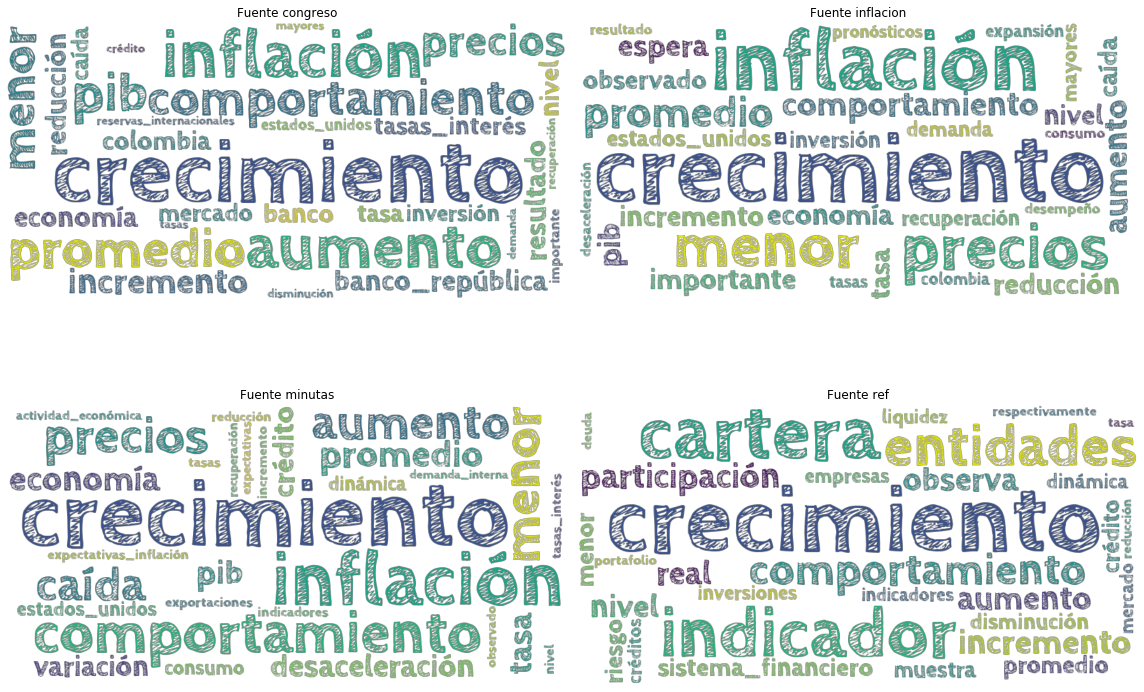

In [36]:
wc_params =dict(font_path="~/Dropbox/datasets/fonts/cabinsketch/CabinSketch-Bold.otf", 
                width=800, height=400, prefer_horizontal=0.6, max_words=30, 
                random_state=2, background_color=None, mode="RGBA", colormap='viridis',)

figwc = plt.figure(figsize=(16, 12))
figwc.subplots_adjust(hspace=0.05, wspace=0.1)

cols = 2
rows = int(np.ceil(bow_fuente.n / cols))

for i in range(bow_fuente.n):
    freq = dict(Counter(toks[i]))
    wc = WordCloud(**wc_params).generate_from_frequencies(freq)

    plt.subplot(rows, cols, i+1).set_title(f"Fuente {fuentes[i]}")
    plt.plot()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")

plt.tight_layout()
plt.savefig(graficas.joinpath('wc_fuentes.png'))

## Modelos de tópicos

### Crear y evaluar múltiples modelos LDA

Los modelos de tópicos se usan para encontrar "temáticas" subyacentes en los textos.

El parámetro básico a especificar en un modelo es el número de tópicos que se quiere considerar en el resultado.

Esta librería usa [Gensim][web_gensim] para la implementación del cálculo de los modelos. En su [documentación][gensim_tuts] encontrará todo lo necesario para correr este tipo de modelos y muchas técnicas adicionales no usadas en esta librería. [banrep][pypi_banrep] simplemente ofrece una forma de correr varios modelos LDA y calificarlos según [Coherence Score][gensim_score], todo basado en Gensim.

[web_gensim]: https://radimrehurek.com/gensim/models/ldamodel.html
[gensim_tuts]: https://radimrehurek.com/gensim/tutorial.html
[pypi_banrep]: https://pypi.org/project/banrep/
[gensim_score]: https://radimrehurek.com/gensim/models/coherencemodel.html

#### Uso de clase: `ModelosLda`

Se usa para crear modelos LDA para diferentes números de tópicos.

Los modelos de tópicos suelen ser evaluados usando una medida llamada *Coherence Score*. Esta medida sugiere qué tan "interpretables" son los modelos. Un mayor score es un modelo más "interpretable", y por lo tanto mejor.

`ModelosLda` devuelve los modelos generados al iterar, donde cada elemento devuelto es un diccionario que contiene el modelo, el *score* y el número de tópicos de ese modelo.

In [37]:
ModelosLda?

Init signature: ModelosLda(bow, kas, params)
Docstring:     
Modelos de tópicos basados en LDA.

Itera Bags of Words de documentos y crea modelos para diferentes k.
Init docstring:
Requiere bow, kas, params.

Parameters
----------
bow : banrep.transforma.Bow
    Colección de documentos Bag of Words.
kas : Iterable[int]
    Diferentes k tópicos para los cuales crear modelo.
params : dict
    Parámetros requeridos en modelos LDA.
    Ver https://radimrehurek.com/gensim/models/ldamodel.html
File:           ~/munozbravo/banrep/banrep/transforma.py
Type:           type
Subclasses:     


In [38]:
# usando el bow generado anteriormente...

kas = (5, 10, 20, 40, 80, 120)
params = dict(passes=10, alpha='auto', eta='auto', random_state=100)

modelos = ModelosLda(bow, kas, params)

ldas = sorted((modelo for modelo in modelos), key=lambda x: x.get("score"), reverse=True)
print(modelos)

Modelos LDA para k en (5, 10, 20, 40, 80, 120): Mejor k=10 con Coherence Score=0.489


In [39]:
modelo = ldas[0].get('modelo')
print(modelo)

LdaModel(num_terms=34677, num_topics=10, decay=0.5, chunksize=2000)


Una vez se tiene un modelo de tópicos generalmente se quiere investigar los resultados, y potencialmente aplicarlo a otros conjuntos de documentos.

### Distribución de probabilidad de tokens en cada tópico de un modelo

Un tópico no es más que una serie de palabras con cierta probabilidad de ocurrir. Las palabras con mayor probabilidad son las que permiten "caracterizar" un tópico. 

#### Uso de función: `tabulados.df_probables`

Genera un DataFrame con las palabras más probables de cada tópico en un modelo.

In [40]:
tabulados.df_probables?

Signature: tabulados.df_probables(modelo, n=15)
Docstring:
Distribución de probabilidad de tokens en tópicos de modelo.

Parameters
----------
modelo : gensim.models.ldamodel.LdaModel
n : int optional
    Cuantos tokens incluir.

Returns
-------
pd.DataFrame
    Tokens probables de cada tópico y sus probabilidades.
File:      ~/munozbravo/banrep/banrep/tabulados.py
Type:      function


In [41]:
probables = tabulados.df_probables(modelo, n=20)
probables.head()

token  probabilidad  topico
0     crecimiento      0.066416       0
1        dinámica      0.018276       0
2           menor      0.018137       0
3  comportamiento      0.013482       0
4             pib      0.012802       0

#### *Fuera de `banrep`*
La siguiente celda escribe código usual pero que sin embargo no hace parte de la librería.

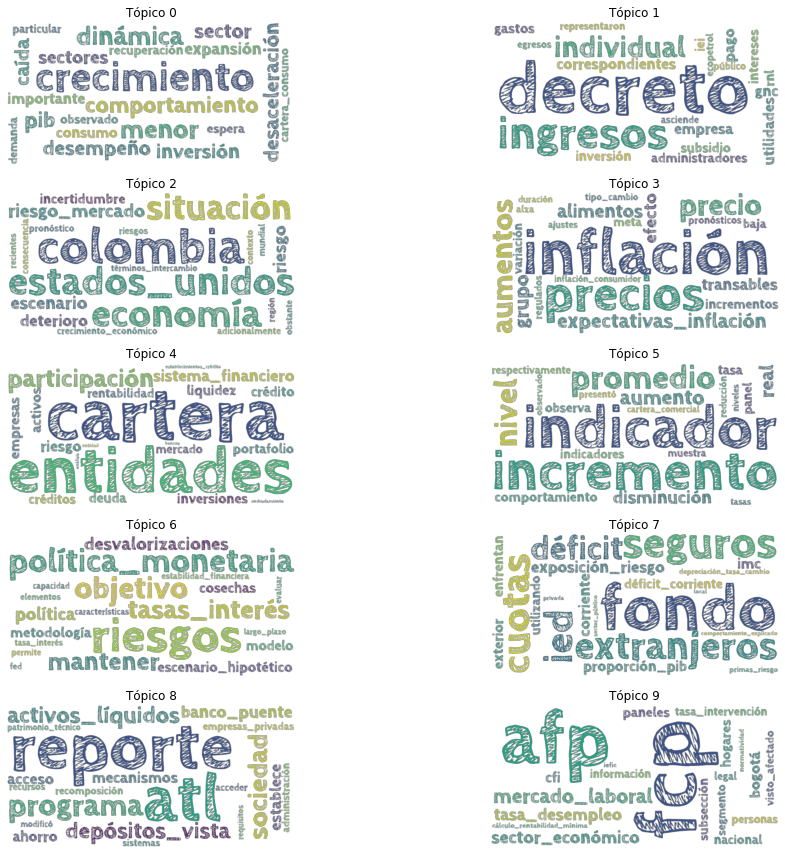

In [42]:
wcfig = plt.figure(figsize=(16, 12))
wcfig.subplots_adjust(hspace=0.05, wspace=0.1)

k = modelo.num_topics
r = int(np.ceil(k / 2))

for t in range(k):
    freq = dict(modelo.show_topic(t, topn=20))
    wc = WordCloud(**wc_params).generate_from_frequencies(freq)

    plt.subplot(r, 2, t+1).set_title(f"Tópico {t}")
    plt.plot()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")

plt.tight_layout()
plt.savefig(graficas.joinpath('wc_topicos.png'))

### Distribución de probabilidad de tópicos de un modelo en cada documento

Usualmente se quiere ver la probabilidad de cada tópico asociada a cada documento. Se puede  pensar un documento como generado de una distribución de probabilidad de tópicos. 

Para cada documento (fila) se quiere la probabilidad de que hable de cada tópico (columna).

In [43]:
# usando el bow generado anteriormente...
doc_ids, toks, sparsed = zip(*bow)

# Document-Feature Matrix
dfm = pd.DataFrame(data=(dict(d) for d in modelo[sparsed]), index=doc_ids)
dfm.tail()

0         2         3         4         5         6         7  \
0044840  0.100959  0.050213  0.016349  0.267075  0.122464  0.201124  0.065089   
0044841  0.070450  0.024725  0.017700  0.349656  0.078141  0.197784  0.074219   
0044842  0.086394  0.062802  0.040563  0.292311  0.204572  0.113191  0.013632   
0044843  0.056045  0.038308  0.025360  0.219077  0.068990  0.322477       NaN   
0044844  0.065804  0.029356  0.030024  0.303319  0.077619  0.090314  0.019386   

                1         8         9  
0044840  0.166847       NaN       NaN  
0044841  0.040640  0.110603  0.036084  
0044842  0.014282  0.089710  0.082542  
0044843       NaN  0.200589  0.051708  
0044844  0.020354  0.340059  0.023766

Basado en esta distribución, se quiere saber la "prevalencia" de cada tópico: en cuantos documentos del corpus es dominante (el de mayor probabilidad).

In [44]:
dom = dfm.idxmax(axis=1).value_counts(normalize=True)
dom.index.name = "topico"
dom = dom.to_frame(name="domina").reset_index()

dom.head()

topico    domina
0       5  0.264962
1       0  0.256422
2       4  0.138676
3       2  0.128709
4       3  0.109727

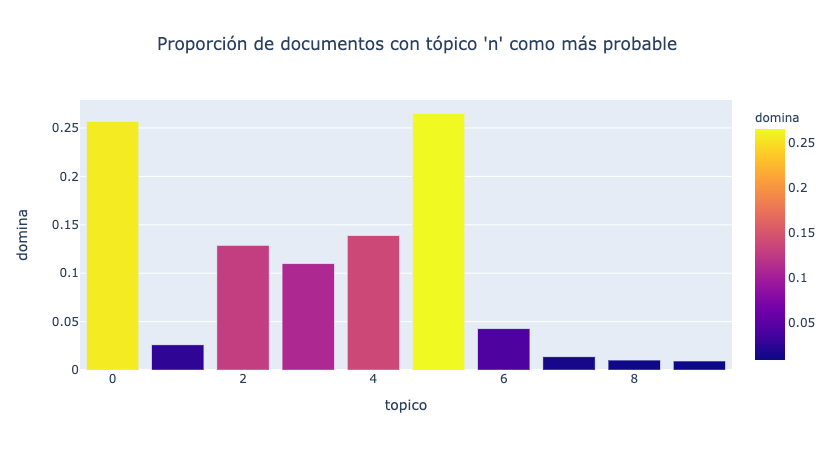

In [45]:
fig = px.bar(dom, 'topico', 'domina', color='domina',
             title="Proporción de documentos con tópico 'n' como más probable")

fig.update_layout(title_x=0.5)
fig.write_html(file=str(graficas.joinpath('prevalencia.html')), auto_open=False)
fig.show()

### Distancia entre tópicos de un modelo

A veces se puede necesitar saber qué tan diferentes son entre ellos los tópicos de un modelo. El resultado puede ser usado para graficar la distancia, posiblemente usando un heatmap donde cada celda representaría la distancia entre dos tópicos.

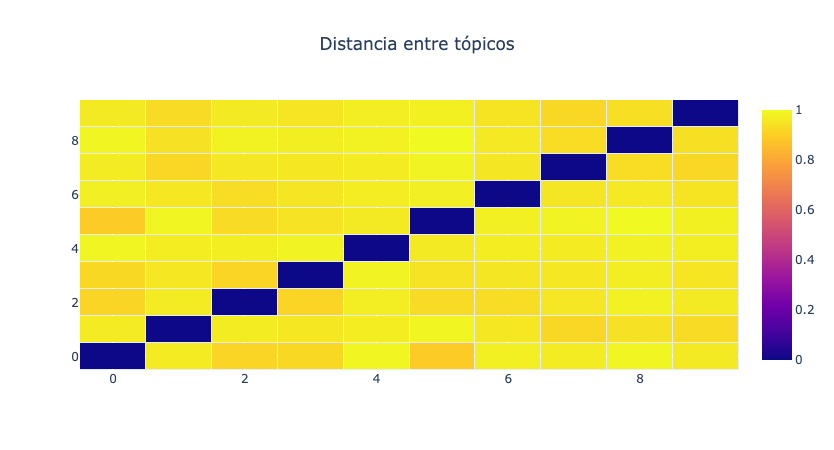

In [46]:
diff, annos = modelo.diff(modelo, distance="hellinger", annotation=True)

labels = list(range(modelo.num_topics))

fig = go.Figure(data=go.Heatmap(z=diff, x=labels, y=labels, xgap=1, ygap=1),)
fig.update_layout(title_text="Distancia entre tópicos", title_x=0.5)
fig.write_html(file=str(graficas.joinpath('distancia.html')), auto_open=False)
fig.show()

### Visualización PyLDAvis (opcional)

En análisis de tópicos se suele usar PyLDAvis para visualizar resultados de un modelo.

La visualización es muy útil para entender la diferencia entre tópicos (distancia entre los círculos de la gráfica en costado izquierdo), prevalencia de cada tópico (tamaño de cada círculo), y el contenido de cada tópico (palabras más probables desplegadas en costado derecho para cada círculo).

El único "*pero*" es que suele generar advertencias de uso "obsoleto" (DeprecationWarning).

**Nota:** *La numeración de tópicos en `PyLDAVIS` comienza en 1, de tal forma que la información de tópico 1 en la gráfica corresponde al tópico 0 en el modelo.*

In [47]:
import warnings
import pyLDAvis
import pyLDAvis.gensim

In [48]:
# Gráfica LDAvis de tópicos y sus palabras
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    vis = pyLDAvis.gensim.prepare(modelo, sparsed, bow.id2word, sort_topics=False)

pyLDAvis.display(vis)

### Aplicar modelo a otro corpus (opcional)

Una vez ha entrenado un modelo, puede incluso aplicárselo a otro corpus. Sólo hay que aplicarle el mismo tipo de preprocesamiento y filtros a los datos.

Por ejemplo, en este caso el modelo se entrenó por párrafo, pero puedo estar interesado en la distribución de probabilidad de tópicos *para cada archivo de texto*.

*En un escenario ideal, su fuente de datos es tan amplia que no necesita entrenar a nivel de párrafos. Se necesitan bastantes documentos para entrenar un modelo de tópicos*.

In [49]:
bow_archivo = Bow(frases, ngrams, 'archivo')

Diccionario con 34677 términos creado...


In [50]:
doc_ids, toks, sparsed = zip(*bow_archivo)

# Document-Feature Matrix
dfm = pd.DataFrame(data=(dict(d) for d in modelo[sparsed]), index=doc_ids)
dfm.sort_index(inplace=True)
dfm.tail()

0         1         2         3         4         5  \
2019-05.txt  0.171351  0.039782  0.101646  0.038009  0.240373  0.208916   
2019-06.txt  0.329964  0.019434  0.110084  0.208880  0.027239  0.191557   
2019-07.txt  0.200879  0.020466  0.224545  0.073966  0.042080  0.175756   
2019-08.txt  0.244384  0.045057  0.160775  0.106287  0.084023  0.185644   
2019-09.txt  0.217599  0.017150  0.179756  0.087972  0.046158  0.178530   

                    6         7         8         9  
2019-05.txt  0.090519  0.026962  0.057740  0.024702  
2019-06.txt  0.040477  0.017319  0.014062  0.040985  
2019-07.txt  0.220137       NaN  0.029194  0.011220  
2019-08.txt  0.058803  0.036595  0.030106  0.048326  
2019-09.txt  0.206259  0.016948  0.040277       NaN

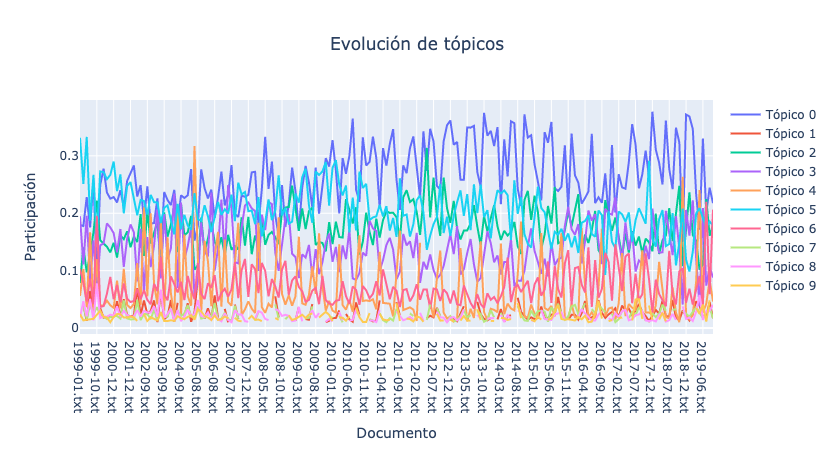

In [51]:
traces = []
for i in dfm.columns:
    traces.append(go.Scatter(x=dfm.index, y=dfm[i], 
                             line=dict(width=2), name=f'Tópico {i}'))

fig = go.Figure(data=traces)
fig.update_layout(title_text="Evolución de tópicos", title_x=0.5,
                  xaxis_title='Documento', yaxis_title='Participación',
                  yaxis=dict(automargin=True, hoverformat='.2f'))

fig.write_html(file=str(graficas.joinpath('doctopics.html')), auto_open=False)
fig.show()

## Almacenamiento de objetos generados

`Bow` y `ModelosLda` generan estructuras que pueden ser útiles más adelante, y por lo tanto se quiere guardar a disco.

Se quiere usualmente almacenar los modelos de "ngramas", el "diccionario" que contiene todas las palabras únicas existentes en el corpus (producido por `Bow`), el mejor modelo de tópicos (producido por `ModelosLda`).

### Guardar n-gramas, diccionario y mejor modelo LDA

In [52]:
mpath = crear_carpeta(carpeta.joinpath('modelos'))

#Guardar modelos de bigramas y trigramas
ngrams.get('bigrams').save(str(mpath.joinpath('bigrams')))
ngrams.get('trigrams').save(str(mpath.joinpath('trigrams')))

# Guardar diccionario
bow.id2word.save(str(mpath.joinpath('id2word')))

# Guardar mejor modelo
modelo.save(str(mpath.joinpath(f'topicos-{modelo.num_topics:0>2}.lda')))